# Deep Learning &mdash; Assignment 6

Assignment for week 6 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a graph neural network, using pytorch geometric
2. Compare a GNN with other network architectures
3. Compare different GNN layers and aggregation functions

## Required software

As before you will need these libraries:
* `torch`, `torch-sparse`, `torch-scatter`, and `torch-geometric` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

The recommended way to install these libraries is described in the [torch-geometric installation instructions](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [1]:
# Replace ${TORCH} and ${CUDA} with your torch and cuda versions.
# Or remove the -f argument to compile from source
#
#!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
#!pip install torch-geometric

In [2]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch import nn
from torch.nn import Linear, Dropout
from torch.nn import functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv

/lustre/home/lmucko/.local/lib/python3.10/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /lustre/home/lmucko/.local/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/lustre/home/lmucko/.local/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /lustre/home/lmucko/.local/lib/python3.10/site-packages/torch_sparse/_metis_cuda.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## 6.1 A node classification dataset (1 point)

In this assignment we will be working on a node classification problem using the Citeseer dataset. This is a graph dataset that contains bag-of-words representation of documents and citation links between the documents. So there is an edge between document $i$ and document $j$ if one cites the other. This is an undirected edge.

In [3]:
dataset = Planetoid(root='data', name='Citeseer', transform=NormalizeFeatures())

**(a) How many graphs are there in this dataset? How large are they (in terms of nodes and edges)?<span style="float:right"> (1 point)</span>**

In [4]:
# TODO: your answer here
print(f'Number of graphs: {len(dataset)}')
print(f"Number of nodes: {dataset[0].num_nodes}")
print(f"Number of edges: {dataset[0].num_edges}")

Number of graphs: 1
Number of nodes: 3327
Number of edges: 9104


In fact, we will continue the rest of this notebook using the first graph from the dataset.

In [5]:
data = dataset[0]  # Get the first graph object.

We will be use a subset of the nodes for training, and another subset for testing.
These subsets are indicated by `data.train_mask` and `data.test_mask` respectively.

## 6.2 MLP for node classification (6 points)

In theory, we should be able to classify documents based only on their content, that is, using the bag-of-words features, without taking the graph structure into account.

We can verify that by constructing a simple node-wise multilayer perceptron with a single hidden layer. This network does not use the edge information at all.

**(a) Complete the code below.<span style="float:right"> (2 points)</span>**

The network should have 2 linear layers. The hidden layer should have size `hidden_channels`, use ReLU activations, and use dropout with a dropout rate of 0.1. Don't use an activation function after the final layer.

Hint: avoid using `Sequential`, it will make the assignment harder later on.

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        self.lin1 = torch.nn.Linear(num_features, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)
        return x

**(b) Complete the training loop below.<span style="float:right"> (2 points)</span>**

Hint: compute the loss only on the training nodes.

Hint 2: `data.x` contains the features for each node, `data.y` contains their labels.

Hint 3: `model()` takes two parameters: a tensor of node features, and a tensor of edges. See the `test_accuracy` function.

In [13]:
device = d2l.try_gpu()

def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

def test(model, data):
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        # Compute loss and accuracy only on the 'test' nodes
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        test_acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        # Compute loss and accuracy only on the 'train' nodes
        train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
        return train_loss, train_acc, test_loss, test_acc

def train(model, data, lr=0.01, weight_decay=5e-4, epochs=400, plot=True, device="cuda"):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()
    if plot:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], figsize=(10, 5),
                                legend=['train loss', 'train accuracy', 'test loss', 'test accuracy'])
    
    for epoch in range(1, epochs+1):
        model.train()
        # TODO: Compute and optimize loss
        out = model(data.x[data.train_mask], data.edge_index)
        loss = loss_fn(out, data.y[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Compute test accuracy, and plot
        if plot and epoch % 10 == 0:
            train_loss, train_acc, test_loss, test_acc = test(model, data)
            animator.add(epoch + 1, (train_loss, train_acc, test_loss, test_acc))
    
    # Print final accuracy
    train_loss, train_acc, test_loss, test_acc = test(model, data)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

**(c) Now construct and train an MLP on this dataset.<span style="float:right"> (1 point)</span>**

Train loss: 0.0842, Train accuracy: 1.0000
Test loss: 1.2155, Test accuracy: 0.5970


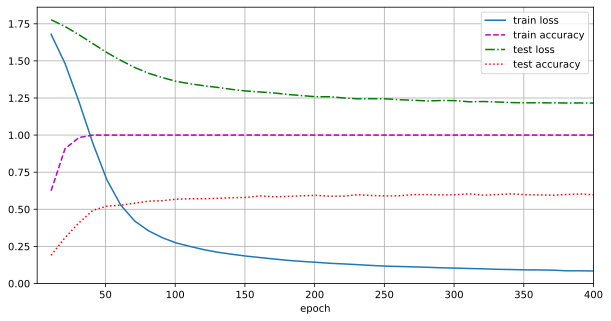

In [16]:
# TODO: construct and train the model
num_features = data.x.shape[1]
num_classes = len(torch.unique(data.y))
mlp_model = MLP(num_features, num_classes)
train(mlp_model, data)

**(d) The MLP network does not use the citation information at all. Give a way to incorporate the edge information without using a graph neural network?<span style="float:right"> (1 point)</span>**

Note that the method should still work for arbitrary citation graphs.

TODO: your answer here

## 6.3 A graph convolutional neural network (3 points)

Next, we will use a graph neural network based on the Graph Convolutional Network approach, which was introduced in the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).

**(a) Implement a graph convolutional neural network, by replacing the linear layers in the MLP with [`GCNConv` layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), and train the network.<span style="float:right"> (1 point)</span>**

The network should have two `GCNConv` layers. The rest of the architecture should stay as close as possible to the MLP.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        # TODO: initialize network layers

    def forward(self, x, edge_index):
        # TODO: compute network output

# TODO: construct and train the model
gcn_model = ...

**(b) Compare the results of the MLP and the GCN. Which model is better?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(c) Has the GCN training converged? Can you expect higher test accuracies by training longer? Explain your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

## 6.4 Comparing GNN layers (8 points)

Two graph layers that are interesting to compare are [`SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). Aside from one of them supporting weighted graphs, these models differ only in the accumulation function.

**(a) Look at the documentation for these two layers. What is the difference in the accumulation function?<span style="float:right"> (1 point)</span>**

TODO: your answer here

To avoid having to copy the GNN structure every time, we can make our code generic in the type of layer to use.

**(b) Make a generic graph neural network, that uses layers of type `layer_type`.<span style="float:right"> (1 point)</span>**

Hint: you can construct layers with `my_layer = layer_type(in_size, out_size, **layer_args)`.

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, layer_type, num_features, num_classes, hidden_channels=16, **layer_args):
        super().__init__()
        # TODO: initialize network layers

    def forward(self, x, edge_index):
        # TODO: same as before

**(c) Train a SAGEConv network and a GraphConv network.<span style="float:right"> (no points)</span>**

In [ ]:
# TODO: construct and train a GNN with SAGEConv layers
sageconv_model = ...

In [ ]:
# TODO: construct and train a GNN with GraphConv layers
graphconv_model = ...

**(d) Compare the performance of these two models, and also compare them to the GCN.<span style="float:right"> (1 point)</span>**

Hint: look at the test loss.

TODO: your answer here

**(e) Can you explain the observation in the previous question by looking at the aggregation functions? Why is one of them worse than the others?<span style="float:right"> (1 point)</span>**

TODO: your answer here

In fact, it is possible to use different aggregation functions, by passing `aggr=` to the network constructor.

**(f) Compute the performance for `GraphConv` networks with `'mean'`, `'sum'`, `'min'`, `'max'`, and `'std'` aggregation.<span style="float:right"> (1 point)</span>**

Hint: train with `plot=False` to only show the final loss and accuracy.

Hint 2: if the performance is the same for all methods, there is most likely a bug in your `GNN` code.

In [ ]:
# TODO: Your experiment here

**(g) Which three aggregation methods are the worst? For each one, explain why that one would not work well.<span style="float:right"> (3 points)</span>**

Hint: bag-of-word features are very sparse.

TODO: your answer here

## 6.5 Discussion (3 points)

**(a) Our training procedure gets the entire graph, including test nodes. Is it possible for the model to cheat using leaked information?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(b) Can the GCN and GNN networks use information from neighbors of neighbors to classify a node? Briefly explain your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(c) Do you think the trained model will generalize to other graphs? Motivate your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 21 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version f502e67 / 2023-10-04</span>